In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns

import base64
import requests

## Importing, curating and exploring historic seismic data from SSN

In [3]:
#Data retrieved from Mexican Seismological Service from UNAM (http://www2.ssn.unam.mx:8080/catalogo/#)
#Data contains 262,782 rows with data from 1900 to September 2022 with historic seisms detection

#data = pd.read_csv('SSNMX_19000101_20221012.csv')

url = 'https://github.com/eflopezruiz/19SeptemberCDMX/blob/64b15e645f4e4851d1d1f49c1602f61827aa5b2f/SSNMX_19000101_20221012.csv?raw=true'
data = pd.read_csv(url,low_memory=False)
print(data.shape)
print(data.info())
data.head(3)

(262782, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262782 entries, 0 to 262781
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       262782 non-null  object 
 1   Hora                        262782 non-null  object 
 2   Magnitud                    262782 non-null  object 
 3   Latitud                     262782 non-null  float64
 4   Longitud                    262782 non-null  float64
 5   Profundidad                 262782 non-null  object 
 6   Referencia de localizacion  262782 non-null  object 
 7   Fecha UTC                   262782 non-null  object 
 8   Hora UTC                    262782 non-null  object 
 9   Estatus                     262782 non-null  object 
dtypes: float64(2), object(8)
memory usage: 20.0+ MB
None


,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1/20/1900,0:33:30,7.4,20.0,-105.0,33,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1/20/1900,6:33:30,revisado
1,5/16/1900,14:12:00,6.9,20.0,-105.0,33,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",5/16/1900,20:12:00,revisado
2,3/5/1901,4:45:00,6.9,25.0,-110.0,33,"100 km al NORESTE de LA PAZ, BCS",3/5/1901,10:45:00,revisado


In [4]:
#Adjust columns to homogenize datatypes 
print(data.Magnitud.unique())

#'No calculable' value is discarded keeping in mind that Magnitude is the main attribute to differ strong from mild seismic events
data = data[data.Magnitud != 'no calculable']
#Magnitud field is then tranformed into float type
data['Magnitud'] = data.Magnitud.astype(float)

print(data.info())

['7.4' '6.9' '7' '7.5' '7.7' '7.1' '7.6' '6.6' '7.2' '6.5' '6.7' '6.8'
 '6.4' '7.8' '8.2' '7.3' '7.9' '4.3' '4.8' '3.5' 'no calculable' '4.4'
 '4.6' '4.5' '5' '5.1' '3.7' '3.1' '4.1' '5.3' '4.9' '4.7' '4.2' '5.4'
 '6.3' '3.3' '5.6' '3.6' '4' '3.9' '5.5' '6' '5.2' '3.8' '3' '6.1' '3.2'
 '3.4' '2.9' '5.7' '5.9' '2.8' '2.7' '2.2' '2.6' '2.5' '1.6' '2.4' '2.1'
 '1.9' '1.5' '2.3' '2' '1.7' '5.8' '6.2' '8.1' '8' '1.8' '1.2' '1.4' '1.3'
 '1' '0.6' '1.1' '0.3' '0.9']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 245133 entries, 0 to 262781
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       245133 non-null  object 
 1   Hora                        245133 non-null  object 
 2   Magnitud                    245133 non-null  float64
 3   Latitud                     245133 non-null  float64
 4   Longitud                    245133 non-null  float64
 5   Profundidad   

First, let's explore the distribution of the magnitude from the seims along historic record 

<AxesSubplot:xlabel='Magnitud', ylabel='Count'>

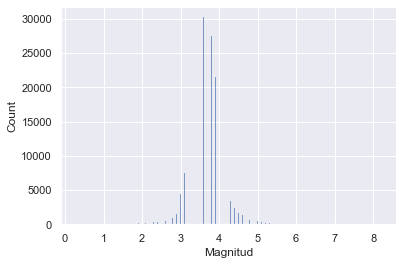

In [5]:
#Plot the distribution of seismic events registered along the historic record
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data = data, x = 'Magnitud')

Normal distribution is plain observed with the 100+ years historic record
<br> Since not every single seismic event is considered an earthquake, as an arbitrary consensus, we will consider just 6.5 magnitude or higher events as relevant eartquakes for the analysis

In [6]:
#Filter just seismic events 6.5 or higher in magnitude
earthQ = data.copy()
earthQ = earthQ[earthQ['Magnitud'] >= 6.5]
print(earthQ.shape)

(217, 10)


Distribution is again plotted with the new sample

<AxesSubplot:xlabel='Magnitud', ylabel='Count'>

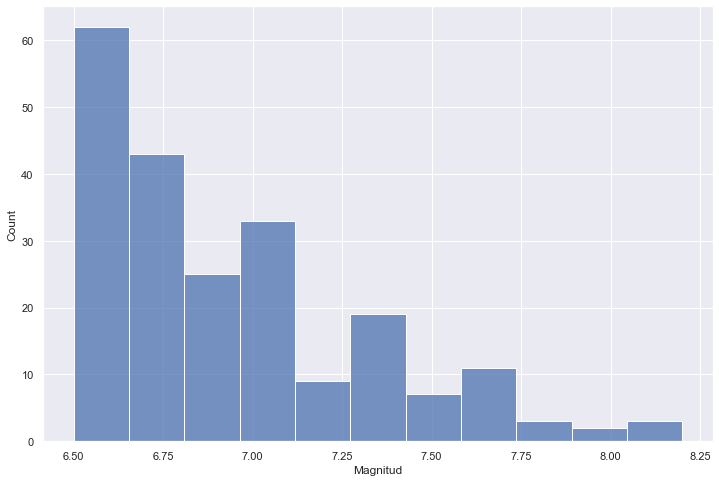

In [7]:
#Plot the distribution of seismic events registered along the historic record
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data = earthQ, x = 'Magnitud')

Now based on the date, let's configure the real incidence of seisms happening in the same calendar date

In [8]:
#Build a calendar date column
#Since the date time is a string type, we will take advantage of it

earthQ['Calendar_date'] = earthQ['Fecha'].str[:-5]

#Add a constant column to count the incidences
earthQ['int'] = 1

#After that with a pivot, we may get to know if any date other than September 19 has presented seismic events
earthQ_count = pd.pivot_table(earthQ,index='Calendar_date', values=['int','Magnitud'], aggfunc={'int':np.sum,'Magnitud':np.mean}).sort_values(by='int', ascending=False).reset_index()
earthQ_count = earthQ_count[earthQ_count['int'] > 2]

<AxesSubplot:xlabel='Calendar_date', ylabel='int'>

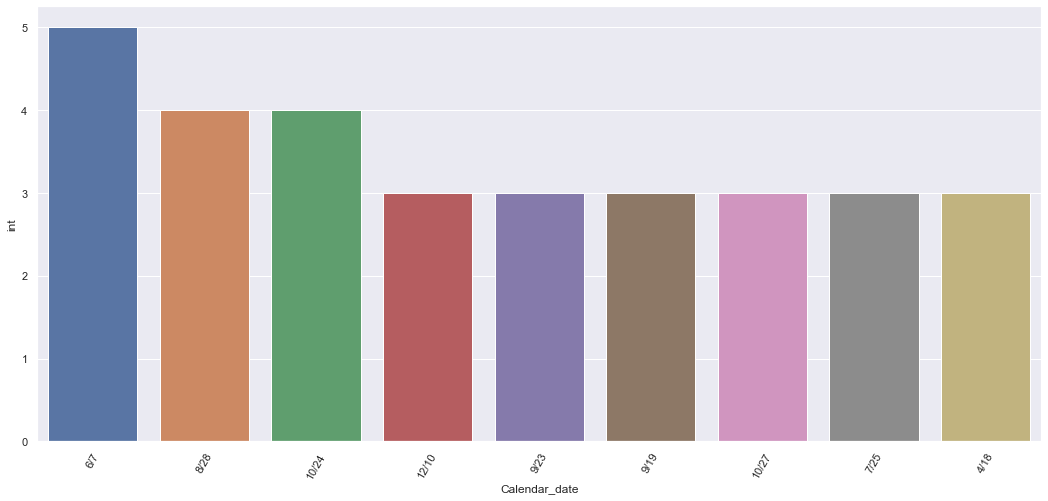

In [9]:
#Use barplot to visualize calendar dates with 2 or more earthquakes since 1900
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(18,8)})
plt.xticks(rotation=60)
sns.barplot(data=earthQ_count, x="Calendar_date", y="int")


## The simulation

In [10]:
from random import seed
import random

This code aims to simulate over iterations, how likely is that 3 seismic events of similar magnitudes happen at the same calendar date

In [11]:
#A counter is set up to track the times an EVENT happens at the same calendar date
count = 0 

#Simulation is iterated 1 M times

for j in range (1000000):
    #Variables to count repetitions and store then in a list
    x = []
    dic = {}
    #Considering that from 1985 to 2022 there have been approximately 40 major earthquakes, the probability 
    #that these events occur on the same day is tracked, NOT that they occur or not. 
    #A list of 40 random elements from 1 to 365 is proposed simulating calendar days
    
    for i in range(40):
        x.append(random.randint(1,365))
    
    #Count of the events by dat is performed and stored in a dictionary
    for z in x: 
        dic[z] = x.count(z)
    
    #Only the counts where there has been 3 events in the same calendar day are stored
    res = {k: v for k, v in dic.items() if v > 2}
    
    #If there was at least a calendar day with a count greater than 3, then counter += 1
    if len(res) > 0:
        count +=1
(count / 1000000) * 100

6.6733